In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import holidays
from datetime import date
from scipy import optimize
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from plotnine import *

Importing plotly failed. Interactive plots will not work.


In [2]:
from scipy.stats.mstats import mquantiles

In [3]:
import theano
import theano.tensor as tt

In [4]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Data Imports

In [5]:
data = pd.read_csv("sales.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]

# 1. Seasonality and Trend Decomposition

To-do
- Convert to method
- Add Holidays optional holidays functionality

In [6]:
from MMM import mmm

In [7]:
START_INDEX = 52
END_INDEX = 144

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append met

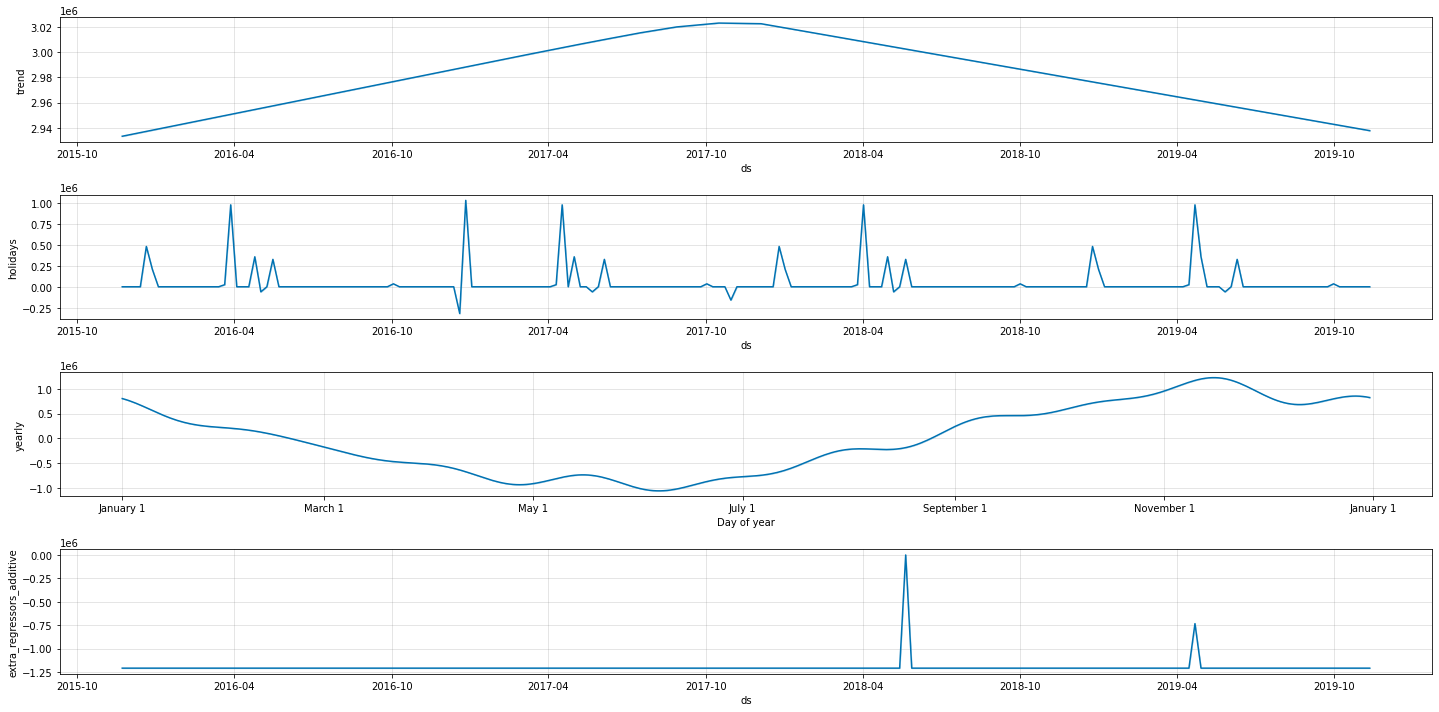

In [8]:
model = mmm(START_INDEX = 52, END_INDEX = 144)
data = mmm.decomposition(model, data)
mmm.plot_decomposition(model)

# 2. Spend-Exposure estimation

In [9]:
media_spend_exposure_df = mmm.estimate_spend_exposure(model, data)

# 3. Scaling and Standardization

In [10]:
#choose features/variables to normalize e.g. only independant variables. 
feature_vars = ["trend", 
                "season", 
                "holiday", 
                "competitor_sales_B", 
                "events", 
                "tv_S", 
                "ooh_S", 
                "print_S",
                "facebook_I", 
                "search_clicks_P", 
                "newsletter"]

target_var = "revenue"

def normalize_data(data, feature_vars):
    data_transformed = data.copy()
    numerical_encoder_dict = {}
    
    for feature in feature_vars:
        scaler = MinMaxScaler()
        original = data[feature].values.reshape(-1, 1)
        transformed = scaler.fit_transform(original)
        data_transformed[feature] = transformed
        numerical_encoder_dict[feature] = scaler
        
    return data_transformed
        
data_transformed = normalize_data(data, feature_vars)
data_transformed[target_var] = data[target_var].values / 100_000

# 4. PYMC3 Model

In [12]:
delay_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"]
control_variables = ["trend", "season", "holiday", "competitor_sales_B", "events"]

mmm.initialize(model, data_transformed, delay_channels, media_channels, control_variables, target_var)

Delay Channels: Adding tv_S


INFO:filelock:Lock 140624615230048 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624615230048 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624615692368 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624615692368 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624620648816 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624620648816 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624619440400 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624619440400

Delay Channels: Adding ooh_S


INFO:filelock:Lock 140624633752256 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624633752256 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding print_S


INFO:filelock:Lock 140624641501984 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624641501984 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding facebook_I


INFO:filelock:Lock 140624628809632 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624628809632 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding search_clicks_P


INFO:filelock:Lock 140624649495216 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624649495216 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding newsletter


INFO:filelock:Lock 140624666886496 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624666886496 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday
Control Variables: Adding competitor_sales_B
Control Variables: Adding events


INFO:filelock:Lock 140624672559984 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624672559984 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624672783568 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624672783568 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624672758944 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624672758944 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624672884192 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624672884192

INFO:filelock:Lock 140624675074688 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624675074688 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624675075216 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624675075216 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624661630208 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624661630208 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624675118288 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624675118288

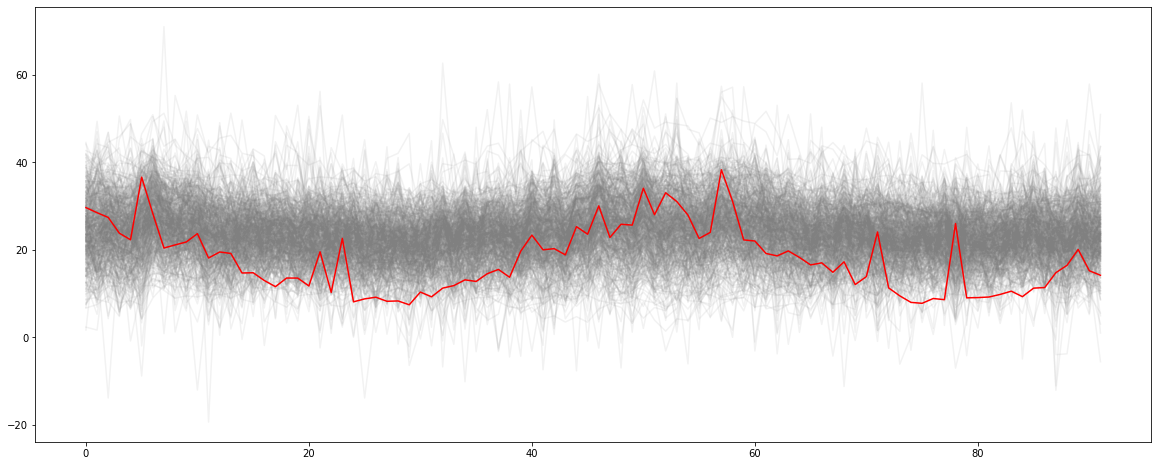

In [13]:
mmm.plot_prior_predictive(model, data_transformed)

In [14]:
trace, trace_summary = mmm.fit(model)

INFO:filelock:Lock 140624703391680 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624703391680 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624711864672 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624711864672 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624711769776 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624711769776 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624714171776 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624714171776

INFO:filelock:Lock 140624327668208 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624327668208 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624328053856 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624328053856 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624328053616 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624328053616 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624330836576 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140624330836576

Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 361 seconds.
INFO:pymc3:Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 361 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [15]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend_control_coef,-2.725,1.457,-5.509,-0.088,0.045,0.050,1041.0,346.0,1.03
season_control_coef,8.501,1.752,5.511,12.086,0.068,0.050,669.0,399.0,1.01
holiday_control_coef,11.985,1.352,9.462,14.592,0.061,0.043,500.0,356.0,1.00
competitor_sales_B_control_coef,11.984,1.792,8.881,15.282,0.069,0.049,681.0,351.0,1.00
events_control_coef,9.248,1.749,5.854,12.704,0.083,0.059,470.0,297.0,1.00
intercept,6.023,1.348,3.306,8.312,0.049,0.037,798.0,374.0,1.00
tv_S_adstock,0.283,0.107,0.070,0.458,0.005,0.003,534.0,371.0,1.01
tv_S_gamma,0.264,0.142,0.090,0.554,0.009,0.006,282.0,333.0,1.01
tv_S_alpha,2.762,1.501,0.693,5.307,0.077,0.055,369.0,344.0,1.01
tv_S_media_coef,4.206,1.324,1.867,6.696,0.076,0.054,284.0,319.0,1.00


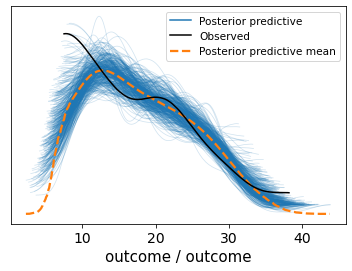

In [16]:
mmm.plot_posterior_predictive(model)

In [17]:
mmm.fit_metrics(model, data)

RMSE: 177081.36299098918
MAPE: 0.06790830067886221
NRMSE: 0.05747065599202137


# 5. Decomposition

In [18]:
#Apply media transformations on data with optimized parameters.
data_transformed_decomposed = mmm.apply_transformations(model, data_transformed)

RMSE: 184864.92180686732
MAPE: 0.06720274927074672
NRMSE: 0.05999676163942234


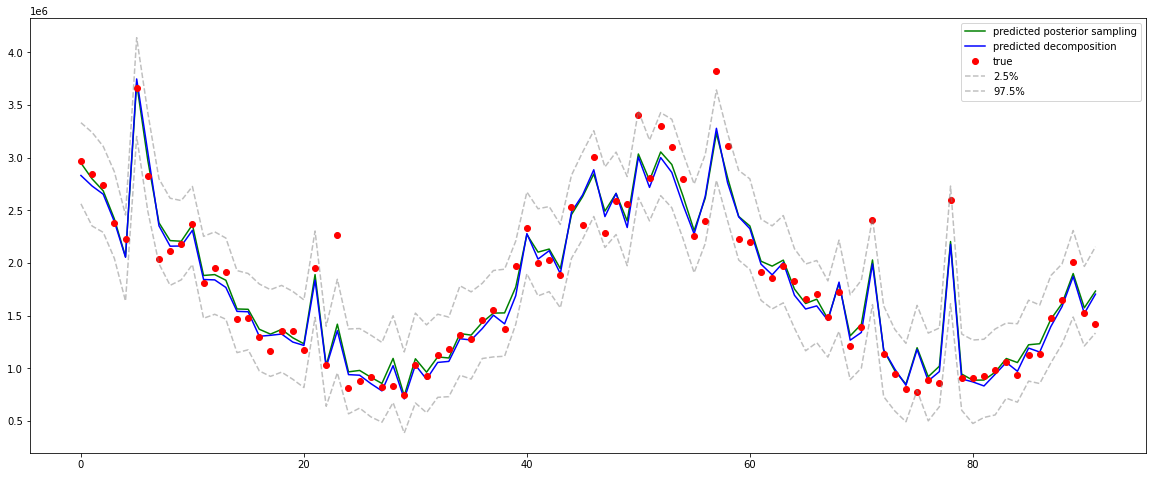

In [19]:
mmm.plot_model_fit(model, data_transformed_decomposed)

In [21]:
spend_response_share_df = mmm.compute_spend_effect_share(model, data, data_transformed_decomposed, media_spend_exposure_df)

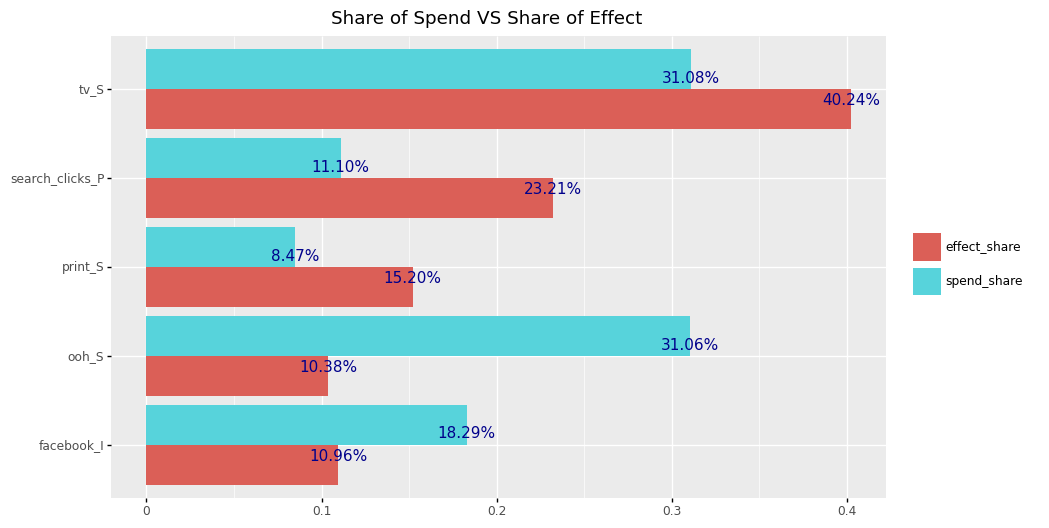

<ggplot: (8788982534391)>

In [23]:
mmm.plot_spend_vs_effect_share(model, spend_response_share_df)